# 透视变换实现

In [1]:
# 导入必要库
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy import interpolate
%matplotlib inline
np.set_printoptions(suppress=True, threshold=np.nan)

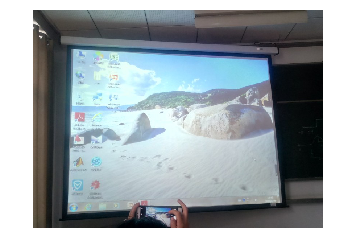

(601, 800, 3)


In [2]:
#img = cv2.imread('.\\data\\5.3.01.tiff',0)
img = cv2.imread('.\\data\\1.jpg')
img= cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

width,height,channels = img.shape

plt.imshow(img,cmap = 'gray')
plt.axis("off")#去除坐标轴
plt.show()

print(img.shape)


## 获取透视变换矩阵

In [3]:
width_new = 400
height_new = 300

pts1 = np.float32([[105,100],[650,135],[90,565],[685,535]])#第一个坐标为横向，第二个为纵向
pts2 = np.float32([[0,0],[width_new,0],[0,height_new],[width_new,height_new]])

M = cv2.getPerspectiveTransform(pts1,pts2)


M_inv = np.linalg.inv(M)
print(M_inv)

[[  1.62506622  -0.07843028 105.6409839 ]
 [  0.14083965   1.38289931 100.61046086]
 [  0.00039115  -0.0003125    1.00610461]]


## 利用手写双线性插值或最临近插值实现透视变换

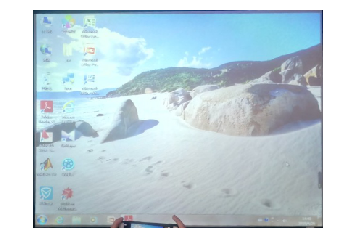

In [4]:
#width_new = 600
#height_new = 400


my_dst = np.zeros(( height_new, width_new ,channels),dtype = np.uint8)

#构建 3 x width_new 大小的矩阵，以计算映射前坐标点
linePixDst = np.zeros((3,width_new),dtype = np.uint16)
linePixDst[0,:] = np.array(range(width_new))
linePixDst[2,:] = 1
n = 0
for i in range(height_new):
    linePixDst[1,:] = i    
    linePixSrc = np.dot(M_inv,linePixDst)
    
    for j in range(width_new):
        pix = linePixSrc[:,j]

        a = np.array([M[2,0]*pix[0]-1,M[2,1]*pix[0],M[2,0]*pix[1],M[2,1]*pix[1]-1]).reshape(2,2)
        b = np.array([-pix[0], -pix[1]]).T

        a_inv = np.linalg.inv(a)
        real_pix = np.dot(a_inv , b)
        
        #采用双线性插值计算坐标--------------------------------------------------
        xInt = int(real_pix[1])
        yInt = int(real_pix[0])
        xFrac = real_pix[1] - xInt
        yFrac = real_pix[0] - yInt
        
        Sx1 = img[xInt,yInt,0] * (1 - xFrac) + img[xInt + 1,yInt,0] * xFrac
        Sx2 = img[xInt,yInt + 1,0] * (1 - xFrac) + img[xInt + 1,yInt + 1,0] * xFrac
        my_dst[i,j,0] = Sx1 * (1 - yFrac) + Sx2 * yFrac

        Sx1 = img[xInt,yInt,1] * (1 - xFrac) + img[xInt + 1,yInt,1] * xFrac
        Sx2 = img[xInt,yInt + 1,1] * (1 - xFrac) + img[xInt + 1,yInt + 1,1] * xFrac
        my_dst[i,j,1] = Sx1 * (1 - yFrac) + Sx2 * yFrac

        Sx1 = img[xInt,yInt,2] * (1 - xFrac) + img[xInt + 1,yInt,2] * xFrac
        Sx2 = img[xInt,yInt + 1,2] * (1 - xFrac) + img[xInt + 1,yInt + 1,2] * xFrac
        my_dst[i,j,2] = Sx1 * (1 - yFrac) + Sx2 * yFrac
        
        #采用最临近插值计算坐标——————————————————————————
        #my_dst[i,j,0] = img[int(real_pix[1]),int(real_pix[0]),0]
        #my_dst[i,j,1] = img[int(real_pix[1]),int(real_pix[0]),1]
        #my_dst[i,j,2] = img[int(real_pix[1]),int(real_pix[0]),2]
        
        
plt.imshow(my_dst)
plt.axis("off")#去除坐标轴
plt.show()

## 与openCV调用实现透视变换对比

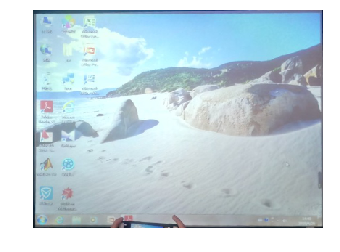

In [5]:
dst = cv2.warpPerspective(img,M,(width_new, height_new))

plt.imshow(dst,cmap = 'gray')
plt.axis("off")#去除坐标轴
plt.show()

#print(my_dst[:,:,0])

## 以下为实验程序（可忽略）

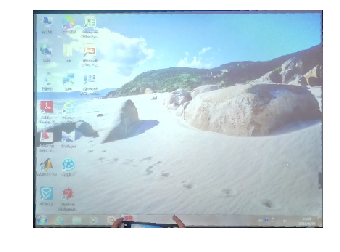

In [6]:
my_dst = np.zeros(( height_new, width_new ,channels),dtype = np.uint8)

#构建 3 x width_new 大小的矩阵，以计算映射前坐标点
linePixDst = np.zeros((3,width_new),dtype = np.uint16)
linePixDst[0,:] = np.array(range(width_new))
linePixDst[2,:] = 1
n = 0
for i in range(height_new):
    linePixDst[1,:] = i    
    linePixSrc = np.dot(M_inv,linePixDst)
    
    for j in range(width_new):
        pix = linePixSrc[:,j]

        a = np.array([M[2,0]*pix[0]-1,M[2,1]*pix[0],M[2,0]*pix[1],M[2,1]*pix[1]-1]).reshape(2,2)
        b = np.array([-pix[0], -pix[1]]).T

        a_inv = np.linalg.inv(a)
        real_pix = np.dot(a_inv , b)
        

        
        #采用最临近插值计算坐标——————————————————————————
        my_dst[i,j,0] = img[int(real_pix[1]),int(real_pix[0]),0]
        my_dst[i,j,1] = img[int(real_pix[1]),int(real_pix[0]),1]
        my_dst[i,j,2] = img[int(real_pix[1]),int(real_pix[0]),2]
        
        
plt.imshow(my_dst)
plt.axis("off")#去除坐标轴
plt.show()

In [14]:
width_new = 400
height_new = 300

x1,y1 = 105,100
x2,y2 = 650,135
x3,y3 = 90,565
x4,y4 = 685,535

A = np.mat([[x1,y1,1,0,0,0,0,0],
              [0,0,0,x1,y1,1,0,0],
              [x2,y2,1,0,0,0,-width_new*x2,-width_new*y2],
              [0,0,0,x2,y2,1,0,0],
              [x3,y3,1,0,0,0,0,0],
              [0,0,0,x3,y3,1,-height_new*x3,-height_new*y3],
              [x4,y4,1,0,0,0,-width_new*x4,-width_new*y4],
              [0,0,0,x4,y4,1,-height_new*x4,-height_new*y4]],dtype=np.float32)
B = np.mat([x1,y1,x2,y2,x3,y3,x4,y4]).T
fa =np.dot(A.I,B)
print(fa)

[[ 0.99999999]
 [ 0.        ]
 [ 0.00000199]
 [-0.00000006]
 [ 1.00000005]
 [-0.0000101 ]
 [-0.        ]
 [ 0.        ]]


In [6]:
def revComputPix(i,j):
        pix = np.dot(M_inv,np.array([i,j,1]).T)

        a = np.array([M[2,0]*pix[0]-1,M[2,1]*pix[0],M[2,0]*pix[1],M[2,1]*pix[1]-1]).reshape(2,2)
        b = np.array([-pix[0], -pix[1]]).T

        a_inv = np.linalg.inv(a)
        real_pix = np.dot(a_inv , b)
        
        print(real_pix)
        
        
width_new = 600
height_new = 400       
[105,100],[650,135],[90,565],[685,535]
[0,0],[600,0],[0,400],[600,400]  


revComputPix(0,0)
revComputPix(600,0)
revComputPix(0,400)
revComputPix(600,400)

[105. 100.]
[650. 135.]
[ 90. 565.]
[685. 535.]


In [7]:
def unDone():
    width_new = 400
    height_new = 300
    dst =  np.zeros((height_new,width_new,3),dtype = np.uint8)
    i = 0

    for i in range(width_new):
        for j in range(height_new):
            computingScaleTemp = (M[2,0]*(105+ i) + M[2,1]*(100 + j) + M[2,2])
            xScale = (M[0,0]*(105+ i) + M[0,1]*(100 + j) + M[0,2]) / computingScaleTemp
            yScale = (M[1,0]*(105+ i) + M[1,1]*(100 + j) + M[1,2]) / computingScaleTemp
            xInt = int(xScale)
            yInt = int(yScale)
            xFrac = xScale - xInt
            yFrac = yScale - yInt

            if(105 + xInt > 601):
                break
            if(100 + xInt > 601):
                break
            Sx1 = img[105 + xInt,100 + yInt,0] * (1 - xFrac) + img[105 + xInt + 1,100 + yInt,0] * xFrac
            Sx2 = img[105 + xInt,100 + yInt + 1,0] * (1 - xFrac) + img[105 + xInt + 1,100 + yInt + 1,0] * xFrac
            dst[i,j,0] = Sx1 * (1 - yFrac) + Sx2 * yFrac

            Sx1 = img[105 + xInt,100 + yInt,1] * (1 - xFrac) + img[105 + xInt + 1,100 + yInt,1] * xFrac
            Sx2 = img[105 + xInt,100 + yInt + 1,1] * (1 - xFrac) + img[105 + xInt + 1,100 + yInt + 1,1] * xFrac
            dst[i,j,1] = Sx1 * (1 - yFrac) + Sx2 * yFrac

            Sx1 = img[105 + xInt,100 + yInt,2] * (1 - xFrac) + img[105 + xInt + 1,100 + yInt,2] * xFrac
            Sx2 = img[105 + xInt,100 + yInt + 1,2] * (1 - xFrac) + img[105 + xInt + 1,100 + yInt + 1,2] * xFrac
            dst[i,j,2] = Sx1 * (1 - yFrac) + Sx2 * yFrac


    '''       Sx1 = img[xInt,yInt,0] * (1 - xFrac) + img[xInt + 1,yInt,0] * xFrac
            Sx2 = img[xInt,100 + yInt + 1,0] * (1 - xFrac) + img[xInt + 1,yInt + 1,0] * xFrac
            dst[i,j,0] = Sx1 * (1 - yFrac) + Sx2 * yFrac

            Sx1 = img[xInt,yInt,1] * (1 - xFrac) + img[xInt + 1,yInt,1] * xFrac
            Sx2 = img[xInt,yInt + 1,1] * (1 - xFrac) + img[xInt + 1,yInt + 1,1] * xFrac
            dst[i,j,1] = Sx1 * (1 - yFrac) + Sx2 * yFrac

            Sx1 = img[xInt,yInt,2] * (1 - xFrac) + img[xInt + 1,yInt,2] * xFrac
            Sx2 = img[xInt,yInt + 1,2] * (1 - xFrac) + img[xInt + 1,yInt + 1,2] * xFrac 

            dst[i,j,2] = Sx1 * (1 - yFrac) + Sx2 * yFrac     '''
        